#### Day-ahead predictions

Putting it together:
- rolling average (to evaluate model performance)
    - plot graph of MAPE over # of additional weeks (to help find optimal amount of train data
- daily performance
    - graph day by day predict and train

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

import pickle

In [2]:
def mape(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Absolute Percentage Error value
    '''
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
#     difference = abs((observations - estimates)/observations)
#     mape = (sum(difference)/len(observations))*100
    mape = np.mean(np.abs((observations - estimates) / observations)) * 100
    return mape

In [3]:
def mse(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    '''
    # check arg types
    assert type(observations) == type(np.array([])), "'observations' must be a numpy array"
    assert type(estimates) == type(np.array([])), "'estimates' must be a numpy array"
    # check length of arrays equal
    assert len(observations) == len(estimates), "Arrays must be of equal length"
    
    # calculations
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)
    
    return mse

In [4]:
dataset = 'PGE-CSI-00114'

with open('pickles/data_'+dataset+'_train0.pickle', 'rb') as to_read:
    data_train = pickle.load(to_read)
with open('pickles/data_'+dataset+'_test0.pickle', 'rb') as to_read:
    data_test = pickle.load(to_read)

In [5]:
with open('pickles/weather_fresno.pickle', 'rb') as to_read:
    weather = pickle.load(to_read)
    
with open('pickles/solar_fresno.pickle', 'rb') as to_read:
    solar = pickle.load(to_read)

### Decomposition

In [9]:
i=180
train_start = dt.datetime(2014,10,1,0,0)
# train_start = dt.datetime(2014,4,1,0,0)
train_end = train_start+dt.timedelta(hours=(24*i-1))

data_train1 = data_train[train_start:train_end]

print(data_train1.shape)

(4320,)


In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

ss_decomposition = seasonal_decompose(x=data_train1, model='additive', freq=24) # what is freq supposed to be?
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


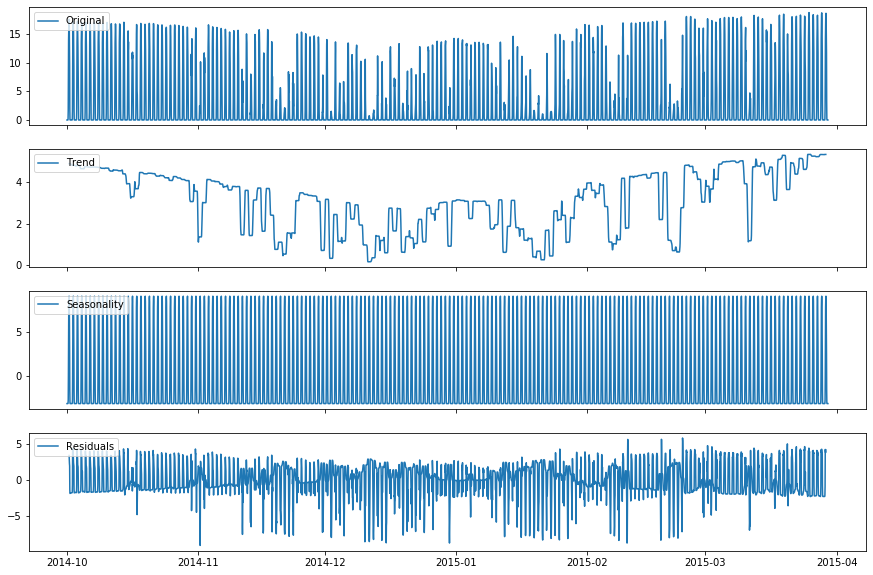

In [11]:
fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
fig.set_figheight(10)
fig.set_figwidth(15)

axes[0].plot(data_train1, label='Original')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals')
axes[3].legend(loc='upper left');

In [12]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    plt.figure(figsize=(20,6))
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw)
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
#     plt.tight_layout()

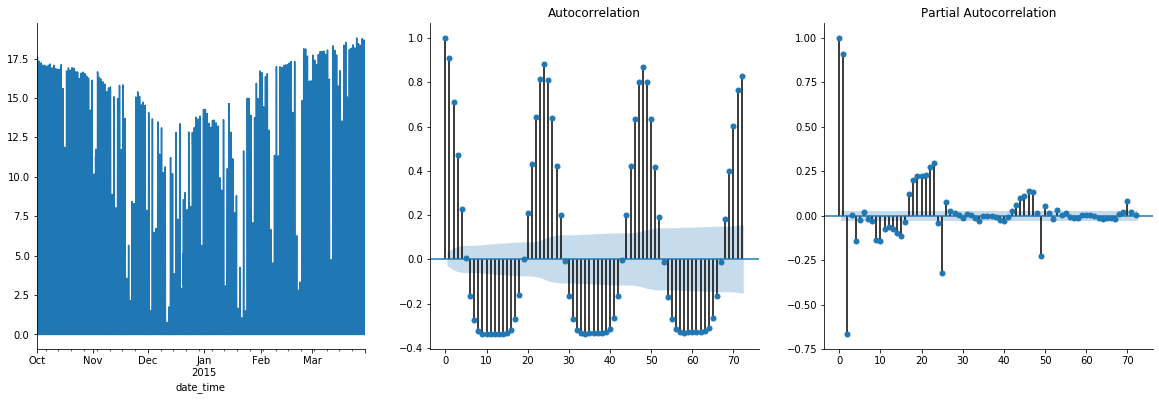

In [13]:
# helper plot for temps
plots(data_train1, lags=72);

### Differencing

In [14]:
from statsmodels.tsa.stattools import adfuller

adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(data_train1)
print(pvalue)

3.1587126019899878e-06


In [15]:
# check daily deviations for various diffs
print(data_train1.std())
print(data_train1.diff().std()) 
print(data_train1.diff().diff().std()) # second order differencing is lowest STD but that might be overdoing it
print(data_train1.diff().diff().diff().std())

5.369767902595875
2.292505929551111
2.0770131323713708
3.020864970461905


### Rolling pseudo out of sample performance
what's the best number of historical days to do the time series on?

In [8]:
import statsmodels.api as sm

In [14]:
def rolling(startdate):
    train_mse = []
    test_mse = []
    train_rmse = []
    test_rmse = []
    train_mape = []
    test_mape = []
    data_for_all = []
    data_test1_all = []

    for i in range(5,15):
        # generate range
        train_start = startdate
        train_end = train_start+dt.timedelta(hours=(24*i-1))
        test_start = train_end+dt.timedelta(hours=1)
        test_end = test_start+dt.timedelta(hours=23)

        #subset data
        data_train1 = data_train[train_start:train_end]
        data_test1 = data_train[test_start:test_end]

        weather_train1 = weather[['sunlight']][train_start:train_end]
        weather_test1 = weather[['sunlight']][test_start:test_end]

        solar_train1 = solar[train_start:train_end]
        solar_test1 = solar[test_start:test_end]

    #     print(data_train1.shape)
    #     print(data_test1.shape)
    #     print(weather_train1.values.shape)
    #     print(weather_test1.values.shape)
    #     print(solar_train1.values.shape)
    #     print(solar_test1.values.shape)

        # model, predict, forecast
        sar = sm.tsa.statespace.SARIMAX(data_train1,
                                    exog=solar_train1.values,
                                    order=(1,1,1), 
                                    seasonal_order=(0,1,1,24), 
                                    trend='c').fit(maxiter=200)

        y_pred = sar.predict(start=0,end=len(data_train1)-1,dynamic=False)
        print(type(y_pred))

        a = data_test1.shape[0]
        data_for = sar.forecast(steps=a,exog=solar_test1.values)

        print(sar.mle_retvals)

        #remove non-0 data during night hours (can't have negative values, which appear to be momentum)
        for i,val in y_pred.iteritems():
            if weather_train1['sunlight'][i] == 0 :
                y_pred[i]=0
            if val < 0 :
                y_pred[i]=0
        for i,val in data_for.iteritems():
            if weather_test1['sunlight'][i] == 0 :
                data_for[i]=0
            if val < 0 :
                data_for[i]=0

        for j in data_for.values:
            data_for_all.append(j)
        for k in data_test1.values:
            data_test1_all.append(k)
        
        train_mse.append(mse(data_train1.values,y_pred.values))
        test_mse.append(mse(data_test1.values,data_for.values))
        train_rmse.append(np.sqrt(mse(data_train1.values,y_pred.values)))
        test_rmse.append(np.sqrt(mse(data_test1.values,data_for.values)))

        #calculate MAPE for non-zero values
        for j,v in data_train1.iteritems():
            if data_train1[j]==0:
                data_train1.pop(j)
                y_pred.pop(j)
        for k,a in data_test1.iteritems():
            if data_test1[k]==0:
                data_test1.pop(k)
                data_for.pop(k)

        train_mape.append(mape(data_train1.values,y_pred.values))
        test_mape.append(mape(data_test1.values,data_for.values))


    #full data
    plt.figure(figsize=(20,6))
    plt.plot(train_mape,alpha=0.5,label='train')
    plt.plot(test_mape,alpha=0.5,label='test')
    plt.title('MAPE')
    plt.xlabel('# of test days')
    plt.legend()
    plt.show();
    
    #test data
    plt.figure(figsize=(20,6))
    plt.plot(data_test1_all,alpha=0.5,label='actual')
    plt.plot(data_for_all,alpha=0.5,label='forecasted')
    plt.title('forecasted vs. actual')
    plt.xlabel('days')
    plt.legend()
    plt.show();
    return

In [15]:
# rolling(dt.datetime(2013,12,2,0,0))

In [16]:
# rolling(dt.datetime(2014,12,1,0,0))

### Daily forecasting for a time period (ndays), using the past x days

In [10]:
def forecast(startdate,x=7,ndays=30):
    train_mse = []
    test_mse = []
    train_rmse = []
    test_rmse = []
    train_mape = []
    test_mape = []
    data_for_all = []
    data_test1_all = []

    for i in range(0,ndays):
        # generate range
        train_start = startdate+dt.timedelta(hours=24*i)
        train_end = train_start+dt.timedelta(hours=(24*x-1))
        test_start = train_end+dt.timedelta(hours=1)
        test_end = test_start+dt.timedelta(hours=23)

        #subset data
        data_train1 = data_train[train_start:train_end]
        data_test1 = data_train[test_start:test_end]

        weather_train1 = weather[['sunlight']][train_start:train_end]
        weather_test1 = weather[['sunlight']][test_start:test_end]

        solar_train1 = solar[train_start:train_end]
        solar_test1 = solar[test_start:test_end]

    #     print(data_train1.shape)
    #     print(data_test1.shape)
    #     print(weather_train1.values.shape)
    #     print(weather_test1.values.shape)
    #     print(solar_train1.values.shape)
    #     print(solar_test1.values.shape)

        # model, predict, forecast
        sar = sm.tsa.statespace.SARIMAX(data_train1,
                                    exog=solar_train1.values,
                                    order=(1,1,1), 
                                    seasonal_order=(0,1,1,24), 
                                    trend='c').fit(maxiter=250)

        y_pred = sar.predict(start=0,end=len(data_train1)-1,dynamic=False)

        a = data_test1.shape[0]
        data_for = sar.forecast(steps=a,exog=solar_test1.values)

#         print(sar.mle_retvals)

        #remove non-0 data during night hours (can't have negative values, which appear to be momentum)
        for i,val in y_pred.iteritems():
            if weather_train1['sunlight'][i] == 0 :
                y_pred[i]=0
            if val < 0 :
                y_pred[i]=0
        for i,val in data_for.iteritems():
            if weather_test1['sunlight'][i] == 0 :
                data_for[i]=0
            if val < 0 :
                data_for[i]=0

        for j in data_for.values:
            data_for_all.append(j)
        for k in data_test1.values:
            data_test1_all.append(k)
        
        train_mse.append(mse(data_train1.values,y_pred.values))
        test_mse.append(mse(data_test1.values,data_for.values))
        train_rmse.append(np.sqrt(mse(data_train1.values,y_pred.values)))
        test_rmse.append(np.sqrt(mse(data_test1.values,data_for.values)))

        #calculate MAPE for non-zero values
        for j,v in data_train1.iteritems():
            if data_train1[j]==0:
                data_train1.pop(j)
                y_pred.pop(j)
        for k,a in data_test1.iteritems():
            if data_test1[k]==0:
                data_test1.pop(k)
                data_for.pop(k)

        train_mape.append(mape(data_train1.values,y_pred.values))
        test_mape.append(mape(data_test1.values,data_for.values))


    #MAPE for test data
    plt.figure(figsize=(20,6))
    plt.plot(train_mape,alpha=0.5,label='train')
    plt.plot(test_mape,alpha=0.5,label='test')
    plt.title('MAPE')
    plt.xlabel('days')
    plt.legend()
    plt.show();

    #RMSE for test data
    plt.figure(figsize=(20,6))
    plt.plot(train_rmse,alpha=0.5,label='train')
    plt.plot(test_rmse,alpha=0.5,label='test')
    plt.title('RSME')
    plt.xlabel('days')
    plt.legend()
    plt.show();
    
    #test data
    graph_index_a = pd.date_range(startdate,startdate+dt.timedelta(days=ndays+x),freq='H')[:-1]
    graph_index_f = pd.date_range(startdate+dt.timedelta(days=x),startdate+dt.timedelta(days=ndays+x),freq='H')[:-1]
    hist_data = data_train[startdate:startdate+dt.timedelta(days=ndays+x)][:-1]
    solar_data = solar[startdate:startdate+dt.timedelta(days=ndays+x)][:-1]
    weather_data = weather['sunlight'][startdate:startdate+dt.timedelta(days=ndays+x)][:-1]
    
    plt.figure(figsize=(20,6))
#     plt.plot(graph_index,data_test1_all,alpha=0.5,label='actual')
    plt.plot(graph_index_a,hist_data,alpha=0.5,label='actual')
    plt.plot(graph_index_f,data_for_all,alpha=0.5,label='forecasted')
    plt.title('forecasted vs. actual')
    plt.xlabel('days')
    plt.legend()
    plt.show();
    
    plt.figure(figsize=(20,6))
    plt.plot(graph_index_a,solar_data['DHI'],alpha=0.5,label='DHI')
    plt.plot(graph_index_a,solar_data['DNI'],alpha=0.5,label='DNI')
    plt.plot(graph_index_a,solar_data['GHI'],alpha=0.5,label='GHI')
    plt.title('solar irradiance')
    plt.xlabel('days')
    plt.legend()
    plt.show();
    
    return data_test1_all, data_for_all, solar_data, hist_data, weather_data, train_mape, test_mape, graph_index_a, graph_index_f

{'fopt': 0.6404448689375019, 'gopt': array([ 1.63657455e-02,  5.02942295e-02, -1.09003096e-01, -9.06644557e-02,
        6.24262420e-05,  1.98161487e-06,  2.45470311e-08,  8.20749757e-04]), 'fcalls': 990, 'warnflag': 0, 'converged': True, 'iterations': 87}
{'fopt': 0.6198410495376188, 'gopt': array([ 1.51179569e-01, -5.70977347e-02,  1.80316082e-01,  3.81223856e-02,
       -3.16872321e-03,  6.69426736e-06,  6.19902463e-05, -9.85514365e-03]), 'fcalls': 1026, 'warnflag': 0, 'converged': True, 'iterations': 87}
{'fopt': 0.9104091019781522, 'gopt': array([ 4.92548865e-02,  5.43476081e-02,  6.50139256e-02, -6.21210936e-02,
       -1.69640336e-03,  6.56907861e-07, -9.40926392e-04,  2.96589030e-03]), 'fcalls': 1314, 'warnflag': 0, 'converged': True, 'iterations': 115}
{'fopt': 1.004490669983827, 'gopt': array([-0.00074624, -0.00188021,  0.00734309, -0.00141877, -0.00066187,
        0.00123209, -0.00372862, -0.00020404]), 'fcalls': 963, 'warnflag': 0, 'converged': True, 'iterations': 62}
{'fopt

/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


{'fopt': 0.9951539862393943, 'gopt': array([-5.99877507e-03,  4.85076024e-04, -7.70038165e-03, -7.98315005e-03,
        3.33885364e-05, -4.56909954e-05, -7.66583019e-05, -6.45656861e-06]), 'fcalls': 675, 'warnflag': 0, 'converged': True, 'iterations': 63}
{'fopt': 0.45608076009903137, 'gopt': array([-1.07245818e-01, -2.72141270e-03,  5.26902742e-02,  3.21084430e-02,
       -5.85185350e-04,  1.84449955e-05,  1.82976711e-03, -1.17053553e-02]), 'fcalls': 1386, 'warnflag': 0, 'converged': True, 'iterations': 121}
{'fopt': -0.6228458003535713, 'gopt': array([ 0.04597874, -0.46066165,  1.53787002,  0.39452351, -0.04434858,
        0.03807411,  0.12480724, -0.07397777]), 'fcalls': 279, 'warnflag': 0, 'converged': True, 'iterations': 21}
{'fopt': -0.6514610353456215, 'gopt': array([-4.29389260e-02,  4.23577651e-02,  1.42425026e-02, -5.11052490e-03,
        2.29477691e-02,  1.77653129e-02,  1.09168567e-02, -6.18472829e-05]), 'fcalls': 504, 'warnflag': 0, 'converged': True, 'iterations': 37}
{'f

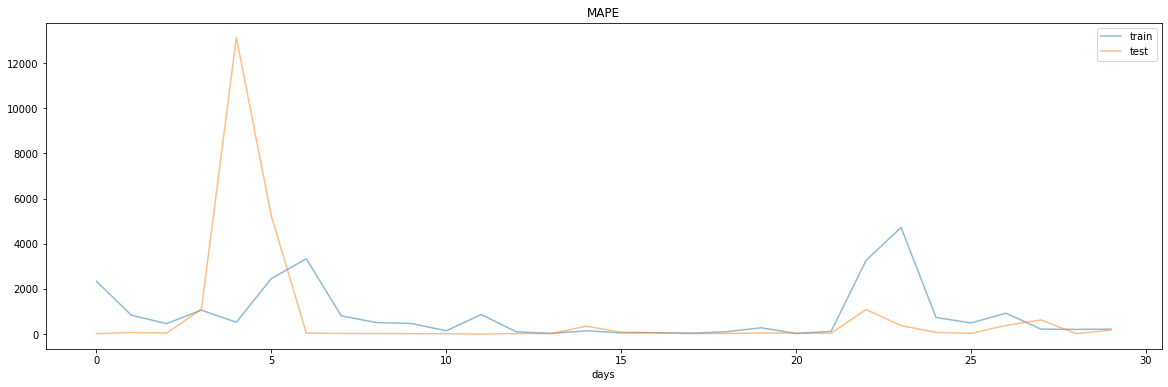

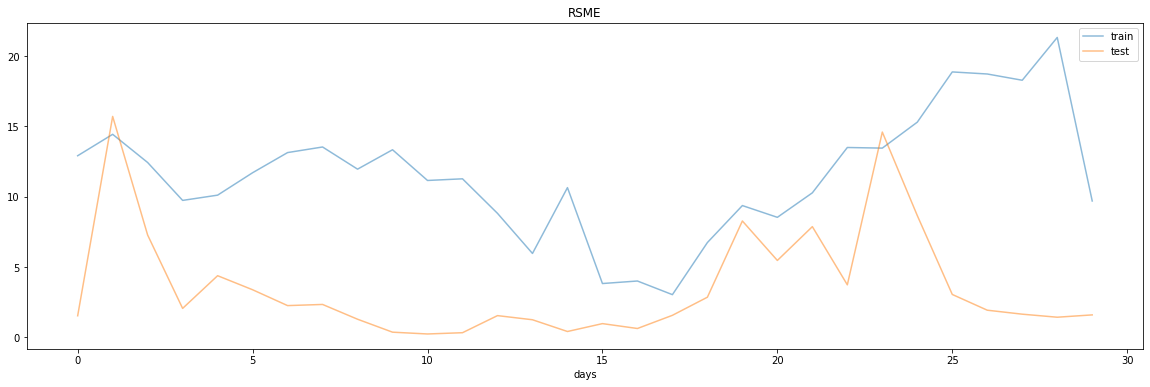

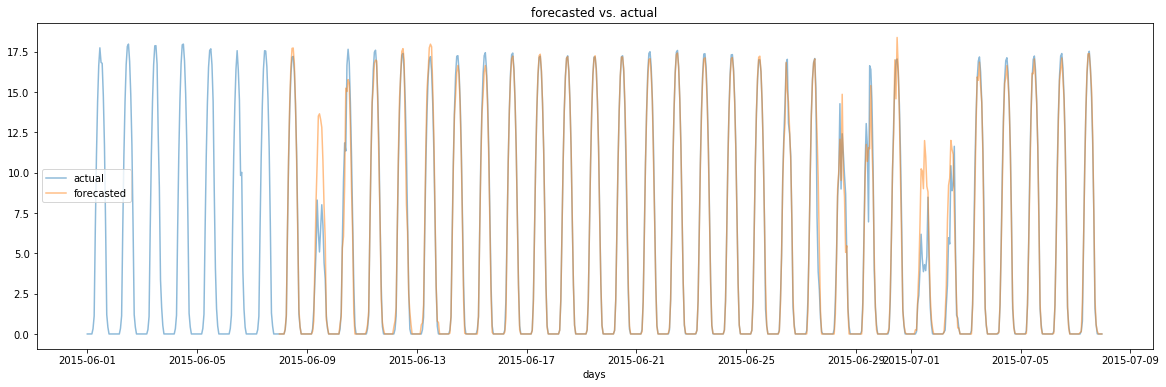

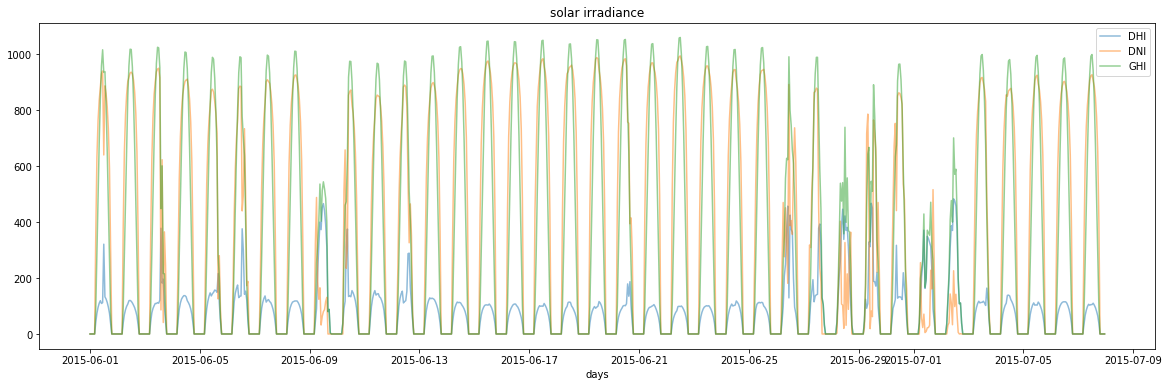

In [18]:
data_test1_all, data_for_all, solar_data, hist_data, weather_data, train_mape, test_mape, graph_index_a, graph_index_f = forecast(dt.datetime(2015,6,1,0,0),ndays=30)

In [19]:
#save out data
historical = hist_data.to_frame()
forecast = pd.DataFrame(data_for_all, index=graph_index_f, columns=['forecast'])
solar = pd.DataFrame(solar_data, index=graph_index_a)
sunlight = weather_data.to_frame()

all_data = pd.merge(historical,forecast,left_index=True,right_index=True,how='left')
all_data = pd.merge(all_data,solar,left_index=True,right_index=True)
all_data = pd.merge(all_data,sunlight,left_index=True,right_index=True)

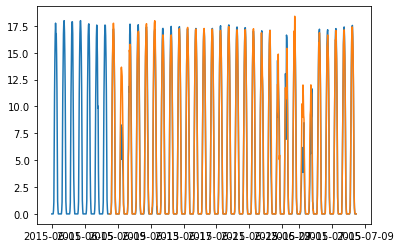

In [20]:
plt.plot(all_data['kWh'])
plt.plot(all_data['forecast']);
# plt.plot(all_data['DNI']);

In [21]:
#mape
forecast_mape = pd.DataFrame(test_mape, index= sorted(list(set(graph_index_f.date))), columns=['MAPE'])
#set spikes to zero?

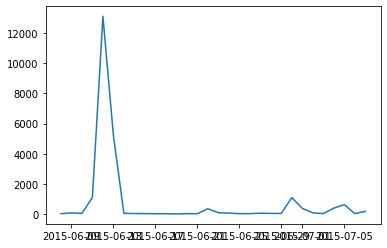

In [22]:
plt.plot(forecast_mape.index, forecast_mape);

In [23]:
all_data.to_csv('output/all_data.csv')
forecast_mape.to_csv('output/forecast_mape.csv')

In [24]:
# save files out for flask app
with open('flask_app/_pickles/all_data.pickle', 'wb') as to_write:
    pickle.dump(all_data, to_write)
with open('flask_app/_pickles/forecast_mape.pickle', 'wb') as to_write:
    pickle.dump(forecast_mape, to_write)

#### Estimate day-ahead for a whole year

/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/statsmodels/base/model.p

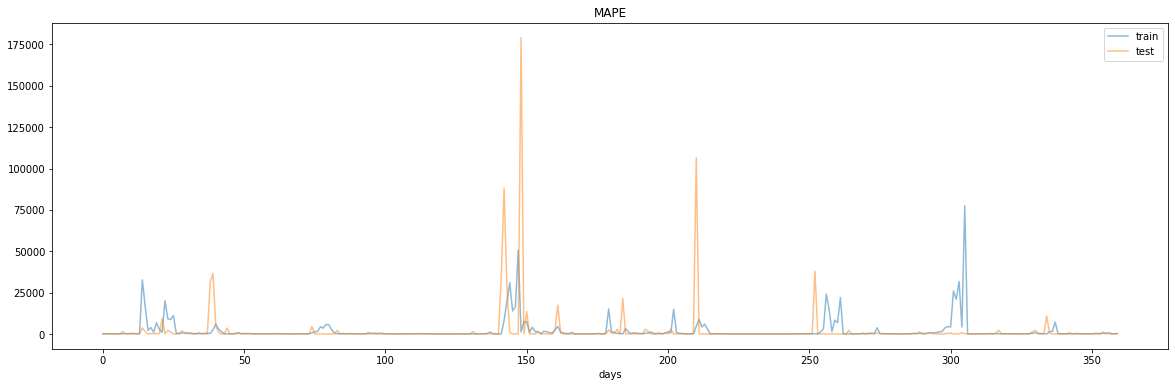

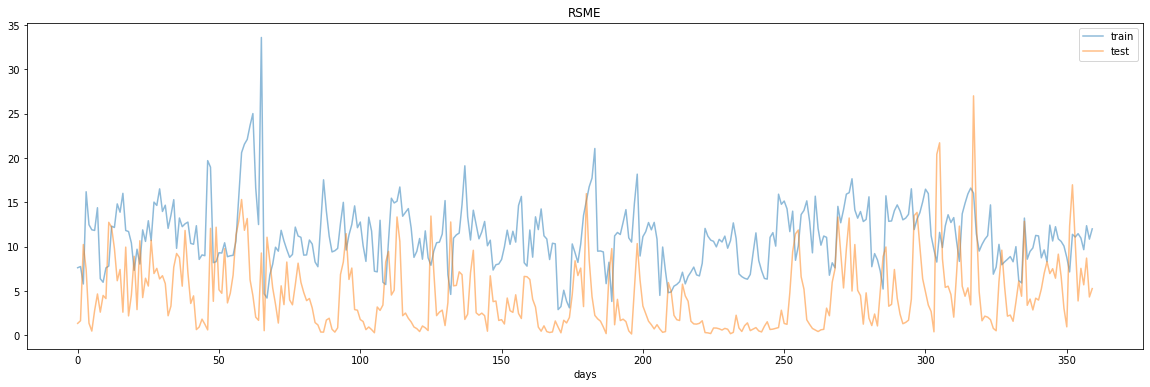

/Users/Jocelyn/anaconda3/envs/metis/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


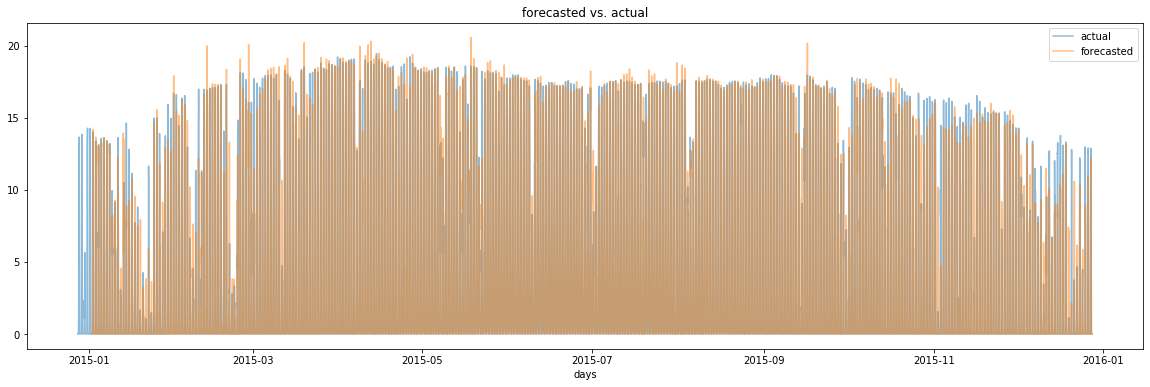

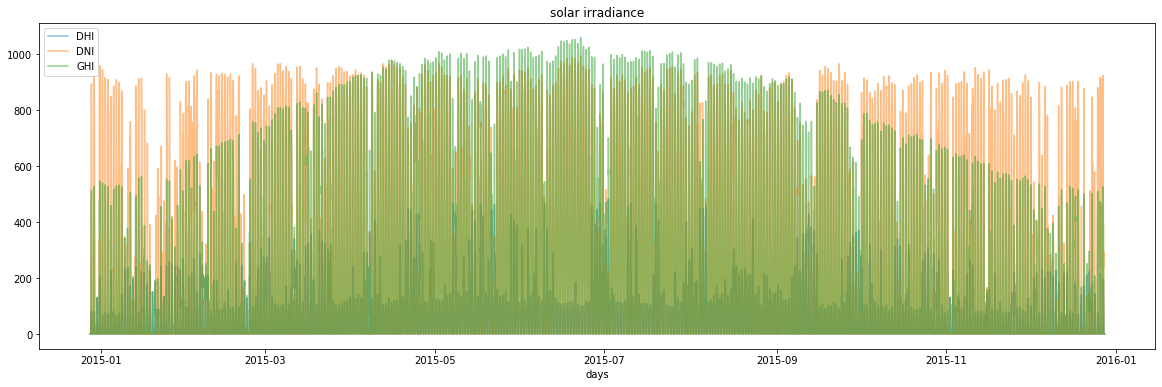

In [12]:
data_test1_all2, data_for_all2, solar_data2, hist_data2, weather_data2, train_mape2, test_mape2, graph_index_a2, graph_index_f2 = forecast(dt.datetime(2014,12,28,0,0),x=5,ndays=360)

In [13]:
#save out data
historical = hist_data2.to_frame()
forecast = pd.DataFrame(data_for_all2, index=graph_index_f2, columns=['forecast'])
solar = pd.DataFrame(solar_data2, index=graph_index_a2)
sunlight = weather_data2.to_frame()

all_data = pd.merge(historical,forecast,left_index=True,right_index=True,how='left')
all_data = pd.merge(all_data,solar,left_index=True,right_index=True)
all_data = pd.merge(all_data,sunlight,left_index=True,right_index=True)

In [15]:
#mape
forecast_mape = pd.DataFrame(test_mape2, index= sorted(list(set(graph_index_f2.date))), columns=['MAPE'])
#set spikes to zero?

In [16]:
all_data.to_csv('output/all_data.csv')
forecast_mape.to_csv('output/forecast_mape.csv')

### Weekly forecasting for a time period (ndays), using the past x days

In [23]:
def forecast_week(startdate,x=30,nweeks=1):
    train_mse = []
    test_mse = []
    train_rmse = []
    test_rmse = []
    train_mape = []
    test_mape = []
    data_for_all = []
    data_test1_all = []

    for i in range(0,nweeks):
        # generate range
        train_start = startdate+dt.timedelta(hours=24*i)
        train_end = train_start+dt.timedelta(hours=(24*x-1))
        test_start = train_end+dt.timedelta(hours=1)
        test_end = test_start+dt.timedelta(hours=24*7-1)

        #subset data
        data_train1 = data_train[train_start:train_end]
        data_test1 = data_train[test_start:test_end]

        weather_train1 = weather[['sunlight']][train_start:train_end]
        weather_test1 = weather[['sunlight']][test_start:test_end]

        solar_train1 = solar[train_start:train_end]
        solar_test1 = solar[test_start:test_end]

    #     print(data_train1.shape)
    #     print(data_test1.shape)
    #     print(weather_train1.values.shape)
    #     print(weather_test1.values.shape)
    #     print(solar_train1.values.shape)
    #     print(solar_test1.values.shape)

        # model, predict, forecast
        sar = sm.tsa.statespace.SARIMAX(data_train1,
                                    exog=solar_train1.values,
                                    order=(1,1,1), 
                                    seasonal_order=(0,1,1,24), 
                                    trend='c').fit(maxiter=250)

        y_pred = sar.predict(start=0,end=len(data_train1)-1,dynamic=False)

        a = data_test1.shape[0]
        data_for = sar.forecast(steps=a,exog=solar_test1.values)

#         print(sar.mle_retvals)

        #remove non-0 data during night hours (can't have negative values, which appear to be momentum)
        for i,val in y_pred.iteritems():
            if weather_train1['sunlight'][i] == 0 :
                y_pred[i]=0
            if val < 0 :
                y_pred[i]=0
        for i,val in data_for.iteritems():
            if weather_test1['sunlight'][i] == 0 :
                data_for[i]=0
            if val < 0 :
                data_for[i]=0

        for j in data_for.values:
            data_for_all.append(j)
        for k in data_test1.values:
            data_test1_all.append(k)
        
        train_mse.append(mse(data_train1.values,y_pred.values))
        test_mse.append(mse(data_test1.values,data_for.values))
        train_rmse.append(np.sqrt(mse(data_train1.values,y_pred.values)))
        test_rmse.append(np.sqrt(mse(data_test1.values,data_for.values)))

        #calculate MAPE for non-zero values
        for j,v in data_train1.iteritems():
            if data_train1[j]==0:
                data_train1.pop(j)
                y_pred.pop(j)
        for k,a in data_test1.iteritems():
            if data_test1[k]==0:
                data_test1.pop(k)
                data_for.pop(k)

        train_mape.append(mape(data_train1.values,y_pred.values))
        test_mape.append(mape(data_test1.values,data_for.values))


    #MAPE for test data
    plt.figure(figsize=(20,6))
    plt.plot(train_mape,alpha=0.5,label='train')
    plt.plot(test_mape,alpha=0.5,label='test')
    plt.title('MAPE')
    plt.xlabel('days')
    plt.legend()
    plt.show();

    #RMSE for test data
    plt.figure(figsize=(20,6))
    plt.plot(train_rmse,alpha=0.5,label='train')
    plt.plot(test_rmse,alpha=0.5,label='test')
    plt.title('RSME')
    plt.xlabel('days')
    plt.legend()
    plt.show();
    
    #test data
    graph_index_a = pd.date_range(startdate,startdate+dt.timedelta(days=nweeks*7+x),freq='H')[:-1]
    graph_index_f = pd.date_range(startdate+dt.timedelta(days=x),startdate+dt.timedelta(days=nweeks*7+x),freq='H')[:-1]
    hist_data = data_train[startdate:startdate+dt.timedelta(days=nweeks*7+x)][:-1]
    solar_data = solar[startdate:startdate+dt.timedelta(days=nweeks*7+x)][:-1]
    weather_data = weather['sunlight'][startdate:startdate+dt.timedelta(days=nweeks*7+x)][:-1]
    
    plt.figure(figsize=(20,6))
    plt.plot(graph_index_a,hist_data,alpha=0.5,label='actual')
    plt.plot(graph_index_f,data_for_all,alpha=0.5,label='forecasted')
    plt.title('forecasted vs. actual')
    plt.xlabel('days')
    plt.legend()
    plt.show();
    
    plt.figure(figsize=(20,6))
    plt.plot(graph_index_a,solar_data['DHI'],alpha=0.5,label='DHI')
    plt.plot(graph_index_a,solar_data['DNI'],alpha=0.5,label='DNI')
    plt.plot(graph_index_a,solar_data['GHI'],alpha=0.5,label='GHI')
    plt.title('solar irradiance')
    plt.xlabel('days')
    plt.legend()
    plt.show();
    
    return data_test1_all, data_for_all, solar_data, hist_data, weather_data, train_mape, test_mape, graph_index_a, graph_index_f

{'fopt': 1.0331914712416215, 'gopt': array([-3.80887926e-03,  7.89218531e-03, -1.21608704e-02, -1.99831340e-03,
       -3.35325789e-04, -1.02227198e-03, -9.11726472e-05,  2.32572406e-05]), 'fcalls': 657, 'warnflag': 0, 'converged': True, 'iterations': 53}
{'fopt': 1.1080377987853791, 'gopt': array([-1.31261997e-03,  7.86762115e-03, -8.71386654e-03, -7.91424575e-03,
        1.99746775e-04, -2.62080380e-04, -8.39870840e-05,  3.38756623e-04]), 'fcalls': 657, 'warnflag': 0, 'converged': True, 'iterations': 54}


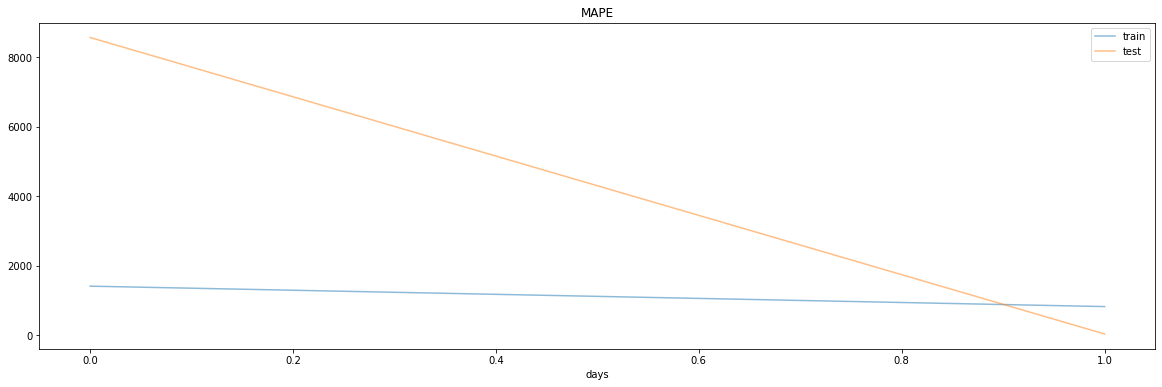

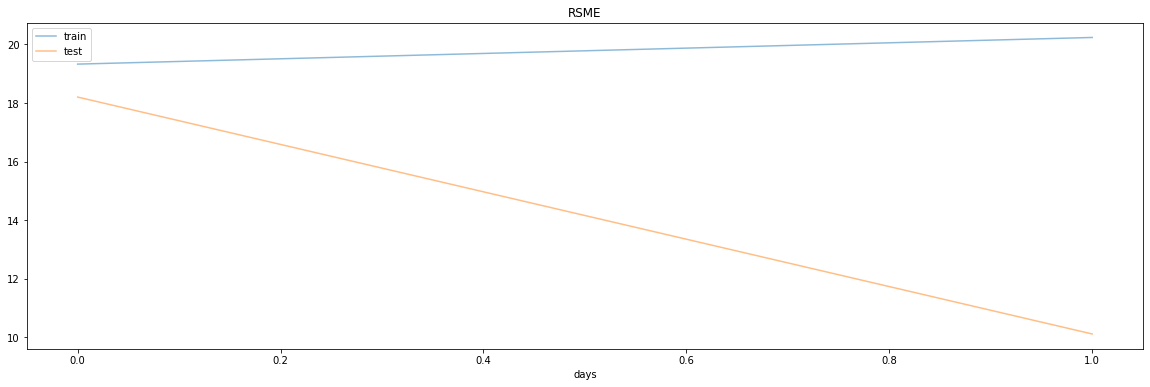

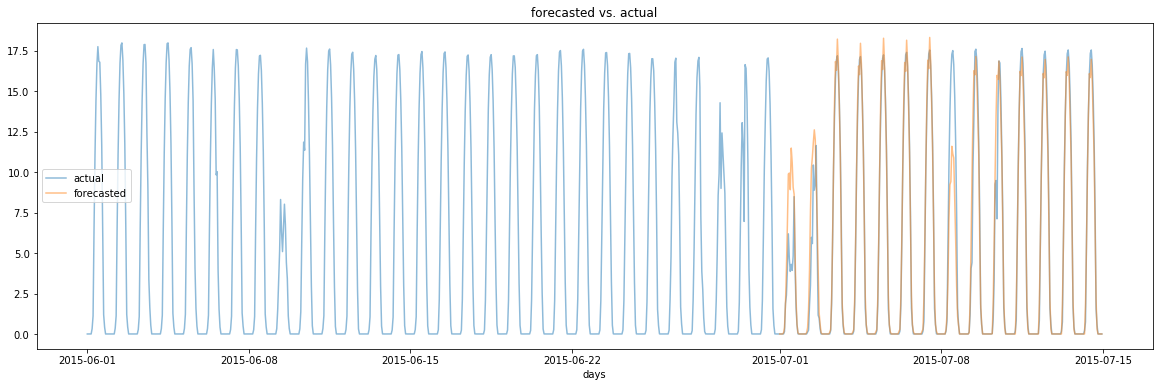

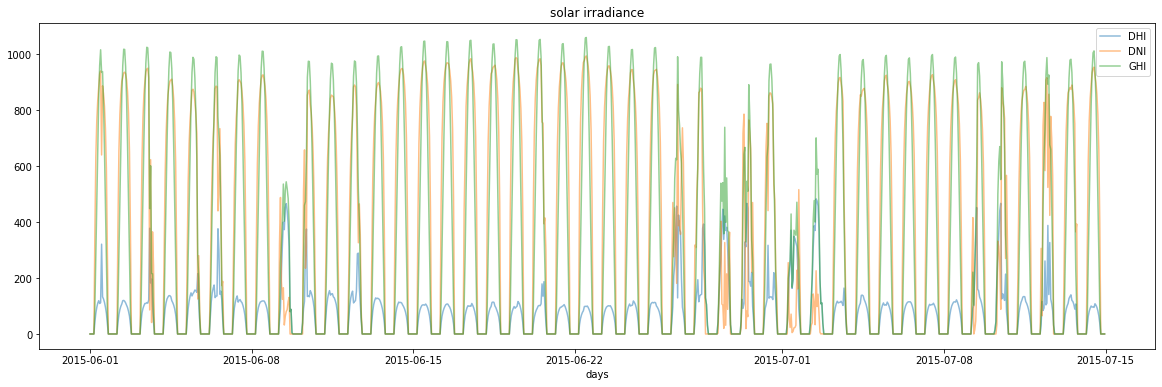

In [26]:
data_test1_all_w, data_for_all_w, solar_data_w, hist_data_w, weather_data_w, train_mape_w, test_mape_w, graph_index_a_w, graph_index_f_w = forecast_week(dt.datetime(2015,6,1,0,0),nweeks=2)